# Main imports and code

In [1]:
# check which gpu we're using
!nvidia-smi

Thu Feb 17 01:52:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:81:00.0  On |                  N/A |
| 40%   26C    P8    28W / 350W |   5164MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [86]:
!pip install simpletransformers
!pip install tensorboardx

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import matplotlib.pyplot as plt

In [3]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [89]:
# if cuda_available:
#   import tensorflow as tf
#   # Get the GPU device name.
#   device_name = tf.test.gpu_device_name()
#   # The device name should look like the following:
#   if device_name == '/device:GPU:0':
#       print('Found GPU at: {}'.format(device_name))
#   else:
#       raise SystemError('GPU device not found')

# Fetch Don't Patronize Me! data manager module

In [90]:
# module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
# module_name = module_url.split('/')[-1]
# print(f'Fetching {module_url}')
# #with open("file_1.txt") as f1, open("file_2.txt") as f2
# with request.urlopen(module_url) as f, open(module_name,'w') as outf:
#   a = f.read()
#   outf.write(a.decode('utf-8'))

In [4]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [5]:
from dont_patronize_me import DontPatronizeMe

In [6]:
dpm = DontPatronizeMe('.', '.')


Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}
1


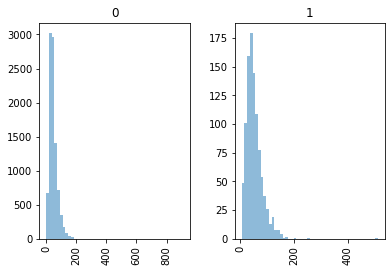

In [7]:
def count_words(sentence):
    return len(sentence.split())
dpm.load_task1()
dpm.load_task2(return_one_hot=True)
df = dpm.train_task1_df
df['lenght'] = df['text'].apply(count_words)
hist = df['lenght'].hist(by=df['label'], bins = 50, alpha = 0.5)
#hist = df['lenght'].hist(by=df['orig_label'], bins = 10, alpha = 0.5)
#hist = df['country'].hist(by=df['label'])
#hist = df['keyword'].hist(by=df['orig_label'])
plt.savefig('histo.jpg', dpi=500)

print(1)

# Load paragraph IDs

In [8]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [9]:
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [10]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

# Rebuild training set (Task 1)

In [11]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [12]:
trdf1 = pd.DataFrame(rows)

# Rebuild test set (Task 1)

In [13]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [14]:
len(rows)

2094

In [15]:
tedf1 = pd.DataFrame(rows)

# RoBERTa Baseline for Task 1

In [16]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
print(training_set1)

     par_id                                               text  label
0      4341  The scheme saw an estimated 150,000 children f...      1
1      4136  Durban 's homeless communities reconciliation ...      1
2     10352  The next immediate problem that cropped up was...      1
3      8279  Far more important than the implications for t...      1
4      1164  To strengthen child-sensitive social protectio...      1
...     ...                                                ...    ...
2377   1775  Last but not the least element of culpability ...      0
2378   1776  Then , taking the art of counter-intuitive non...      0
2379   1777  Kagunga village was reported to lack necessary...      0
2380   1778  "After her parents high-profile divorce after ...      0
2381   1779  "Last night One News reported on leaked Minist...      0

[2382 rows x 3 columns]


In [17]:
training_set1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
2377,1775,Last but not the least element of culpability ...,0
2378,1776,"Then , taking the art of counter-intuitive non...",0
2379,1777,Kagunga village was reported to lack necessary...,0
2380,1778,"""After her parents high-profile divorce after ...",0


In [18]:

# task1_model_args = ClassificationArgs(num_train_epochs=1, 
#                                       no_save=True, 
#                                       no_cache=True, 
#                                       overwrite_output_dir=True)
# task1_model = ClassificationModel("roberta", 
#                                   'roberta-base', 
#                                   args = task1_model_args, 
#                                   num_labels=2, 
#                                   use_cuda=cuda_available)
# # train model
# task1_model.train_model(training_set1[['text', 'label']])
# # run predictions
# preds_task1, _ = task1_model.predict(tedf1.text.tolist())

In [106]:
Counter(preds_task1)

NameError: name 'preds_task1' is not defined

In [ ]:
labels2file([[k] for k in preds_task1], 'task1.txt')

In [19]:
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel

In [20]:
class OlidDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        self.tokenizer = tokenizer
        self.texts = list(input_set['text'])
        self.labels = list(input_set['label'])
        
    def collate_fn(self, batch):

        texts = []
        labels = []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=256)
        encodings['label'] =  torch.tensor(labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        item = {'text': self.texts[idx],
                'label': self.labels[idx]}
        return item

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [22]:
train_dataset = OlidDataset(tokenizer, training_set1)


In [23]:
#returns first item as dictionnary
#print(train_dataset[0])

# put all train set into one batch for the collate_fn function
batch = [sample for sample in train_dataset]

encodings = train_dataset.collate_fn(batch[:10])

for key, value in encodings.items():
  print(f"{key}: {value.numpy().tolist()}")


input_ids: [[101, 1109, 5471, 1486, 1126, 3555, 4214, 117, 1288, 1482, 1121, 2869, 2073, 1217, 1850, 1106, 2192, 1104, 1103, 1418, 2813, 1206, 3598, 1105, 2424, 117, 1118, 2689, 3791, 1105, 18844, 1150, 1163, 1152, 1156, 1730, 1618, 2491, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 12786, 23092, 112, 188, 12501, 3611, 21482, 5953, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1109, 1397, 5670, 2463, 1115, 10809, 3537, 1146, 1108, 1293, 1106, 6043, 1103, 16702, 2337, 117, 1112, 4534, 1104, 1172, 8471, 170, 3485, 10890, 117, 170, 2742, 10890, 117, 1137, 1256, 1126, 4193, 3621, 119, 1109, 2687, 2149, 20832, 4124, 141, 17013, 12320, 1161, 25492, 16736, 10100, 1293, 2403, 2605, 6185, 1122, 1108, 1111, 1140, 1

In [24]:
model = BertModel.from_pretrained("bert-base-cased")

#180 M
print(f"Model size: {model.num_parameters()}")

#model summary
model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model size: 108310272


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [25]:
class BERT_hate_speech(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        # BERT Model
        self.bert = BertModel(config)
        
        # Task A
        self.projection_a = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                                torch.nn.Linear(config.hidden_size, 2))
        
        # Task B
        # TBA
        
        # Task C
        # TBA
        
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
 
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Logits A
        logits_a = self.projection_a(outputs[1])
        
        return logits_a


In [26]:
from transformers import Trainer, TrainingArguments
import torch.nn as nn
class Trainer_hate_speech(Trainer):
    def compute_loss(self, model, inputs):
        labels = {}
        labels['label'] = inputs.pop('label')


        outputs = model(**inputs)

        # TASK A
        loss_task_a = nn.CrossEntropyLoss()
        labels = labels['label']
        loss = loss_task_a(outputs.view(-1, 2), labels.view(-1))
        
        return loss

In [29]:
def main():
    model_name = './models/ht_bert_finetuned/' 
    model = BERT_hate_speech.from_pretrained(model_name)
    #call our custom BERT model and pass as parameter the name of an available pretrained model    
    training_args = TrainingArguments(
        output_dir='./experiment/hate_speech',
        learning_rate = 0.0001,
        logging_steps= 100,
        per_device_train_batch_size=32,
        num_train_epochs = 3,
    )
    trainer = Trainer_hate_speech(
        model=model,                         
        args=training_args,                 
        train_dataset=train_dataset,                   
        data_collator=train_dataset.collate_fn
    )
    trainer.train()

    trainer.save_model('./models/ht_bert_finetuned/')

In [30]:
main()

404 Client Error: Not Found for url: https://huggingface.co/./models/ht_bert_finetuned/resolve/main/config.json


OSError: We couldn't connect to 'https://huggingface.co/' to load this model and it looks like ./models/ht_bert_finetuned is not the path to a directory conaining a config.json file.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

# Rebuild training set (Task 2)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
trdf2 = pd.DataFrame(rows2)

In [ ]:
trdf2

In [ ]:
trdf2.label = trdf2.label.apply(literal_eval)

# Rebuild test set (Task 2)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  label = teids.label[idx]
  #print(parid)
  # select row from original dataset to access the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
tedf2 = pd.DataFrame(rows2)

In [ ]:
tedf2

In [ ]:
tedf2.label = tedf2.label.apply(literal_eval)

# RoBERTa baseline for Task 2

In [ ]:
all_negs = trdf2[trdf2.label.apply(lambda x:sum(x) == 0)]
all_pos = trdf2[trdf2.label.apply(lambda x:sum(x) > 0)]

training_set2 = pd.concat([all_pos,all_negs[:round(len(all_pos)*0.5)]])

In [ ]:
training_set2

In [ ]:
task2_model_args = MultiLabelClassificationArgs(num_train_epochs=1,
                                                no_save=True, 
                                                no_cache=True, 
                                                overwrite_output_dir=True
                                                )
task2_model = MultiLabelClassificationModel("roberta", 
                                            'roberta-base', 
                                            num_labels=7,
                                            args = task2_model_args, 
                                            use_cuda=cuda_available)
# train model
task2_model.train_model(training_set2[['text', 'label']])
# run predictions
preds_task2, _ = task2_model.predict(tedf2.text.tolist())

In [ ]:
labels2file(preds_task2, 'task2.txt')

## Prepare submission

In [ ]:
!cat task1.txt | head -n 10

In [ ]:
!cat task2.txt | head -n 10

In [ ]:
!zip submission.zip task1.txt task2.txt